In [1]:
#!pip install nibabel tqdm scikit-image

In [2]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [3]:
#데이터 셋 가져오기
def get_mask_data():

    x_train_path = "dataset/Image_Segmentation/x_train2.npy"
    x_val_path = "dataset/Image_Segmentation/x_val2.npy" 
    y_train_path = "dataset/Image_Segmentation/y_train2.npy"
    y_val_path = "dataset/Image_Segmentation/y_val2.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    
        
    return x_train, y_train, x_val, y_val


In [4]:
# CNN 인 VGG16 U-net
def VGG16_Unet(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16       #feature map 수
    kernel_size = 3    # kernel size
    copy_layers = []   # Encoder에 있는 Activation map을 저장하는 리스트
    net = inputs
  
    #Encoder1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #첫번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder2 
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #두번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder3
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #세번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder4
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #네번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #Encoder5
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #다섯번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    
    #Decoder : upsampling
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #다섯번째 Activation map 
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #네번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #세번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #두번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #첫번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(2, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                  metrics=['acc',tf.keras.metrics.MeanIoU(num_classes=2)])

    model.summary()
    
    
    

    return model

In [5]:
def Unet(x_train, y_train, x_val, y_val) :
    
    inputs = Input(shape=(256, 256, 1))
    
    f = 16
    layers = []
    net = inputs
  
    for i in range(0, 6):
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        layers.append(net)
        net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
        f = f*2
        #512
    ff2 = 256
  
    #bottleneck 
    j = len(layers) - 1
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, layers[j]])
    j = j -1 
  
    #upsampling 
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        print(net.shape)
        net = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (net)
        print(net.shape)
        net = Concatenate(axis=3)([net, layers[j]])
        j = j -1 
    
  
    #classification 
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    outputs = Conv2D(2, 1, activation='sigmoid') (net)


    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', 'mse', tf.keras.metrics.MeanIoU(num_classes=2)])
    model.summary()
    
    return model

In [6]:
def training(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    
    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')
    

#     preds = model.predict(x_val)
#     fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
#     temp = np.empty((256, 256, 1), dtype=np.float32)

#     for i in range(40):
#         ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
#         ax[i, 0].title.set_text(str(i))
    
#         y_val_0 = y_val[...,0]
#         ax[i, 1].imshow(y_val_0[i].squeeze(), cmap='gray')
    
#         predict_0 = preds[...,0]
#         ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
    
#         temp = x_val[i]
#         pred_sum = predict_0[i][predict_0[i] > 0]
#         pred_mean = np.mean(predict_0)
#         if(np.min(temp) >= 0) :
#             temp[predict_0[i] < 0.5] = 0
#         else :
#             temp[predict_0[i] < 0.5] = -2048
#         ax[i, 3].imshow(temp.squeeze(), cmap='gray')


In [7]:
x_train, y_train, x_val, y_val = get_mask_data()
print(y_train.max(), y_train.min())
print(x_train.max(), x_train.min())
print(x_val.max(), x_val.min())
# model = VGG16_Unet(x_train, y_train2, x_val, y_val2)
# history = training(model,x_train, y_train2, x_val, y_val2)

(2675, 256, 256, 1) (2675, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)
1 0
1.0 0.0
1.0 0.0


(None, 8, 8, 512)
(None, 16, 16, 128)
(None, 16, 16, 256)
(None, 32, 32, 64)
(None, 32, 32, 128)
(None, 64, 64, 32)
(None, 64, 64, 64)
(None, 128, 128, 16)
(None, 128, 128, 32)
(None, 256, 256, 8)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
_______________________________________________________________________________________________

Epoch 1/30
168/168 [==============================] - 103s 540ms/step - loss: 0.7368 - acc: 0.8672 - mse: 0.1157 - mean_io_u: 0.2579 - val_loss: 0.3251 - val_acc: 0.8674 - val_mse: 0.0979 - val_mean_io_u: 0.2500
Epoch 2/30
168/168 [==============================] - 83s 497ms/step - loss: 0.4113 - acc: 0.8644 - mse: 0.0961 - mean_io_u: 0.2568 - val_loss: 0.2828 - val_acc: 0.8702 - val_mse: 0.0828 - val_mean_io_u: 0.2500
Epoch 3/30
168/168 [==============================] - 84s 498ms/step - loss: 0.2429 - acc: 0.9319 - mse: 0.0546 - mean_io_u: 0.2633 - val_loss: 0.1465 - val_acc: 0.9557 - val_mse: 0.0381 - val_mean_io_u: 0.2785
Epoch 4/30
168/168 [==============================] - 84s 498ms/step - loss: 0.1319 - acc: 0.9584 - mse: 0.0336 - mean_io_u: 0.3087 - val_loss: 0.1631 - val_acc: 0.9541 - val_mse: 0.0384 - val_mean_io_u: 0.4985
Epoch 5/30
168/168 [==============================] - 82s 489ms/step - loss: 0.0989 - acc: 0.9669 - mse: 0.0259 - mean_io_u: 0.3589 - val_loss: 0.1436 - va

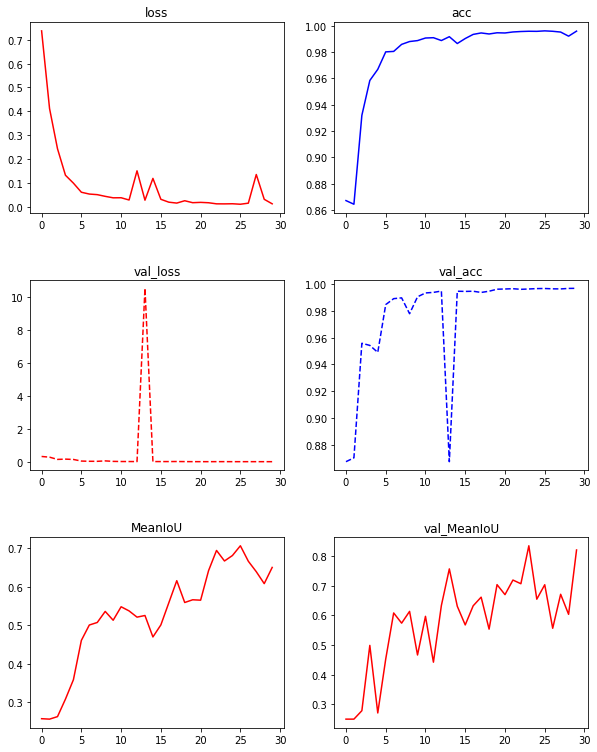

In [8]:
model = Unet(x_train, y_train, x_val, y_val)
history = training(model,x_train, y_train, x_val, y_val)

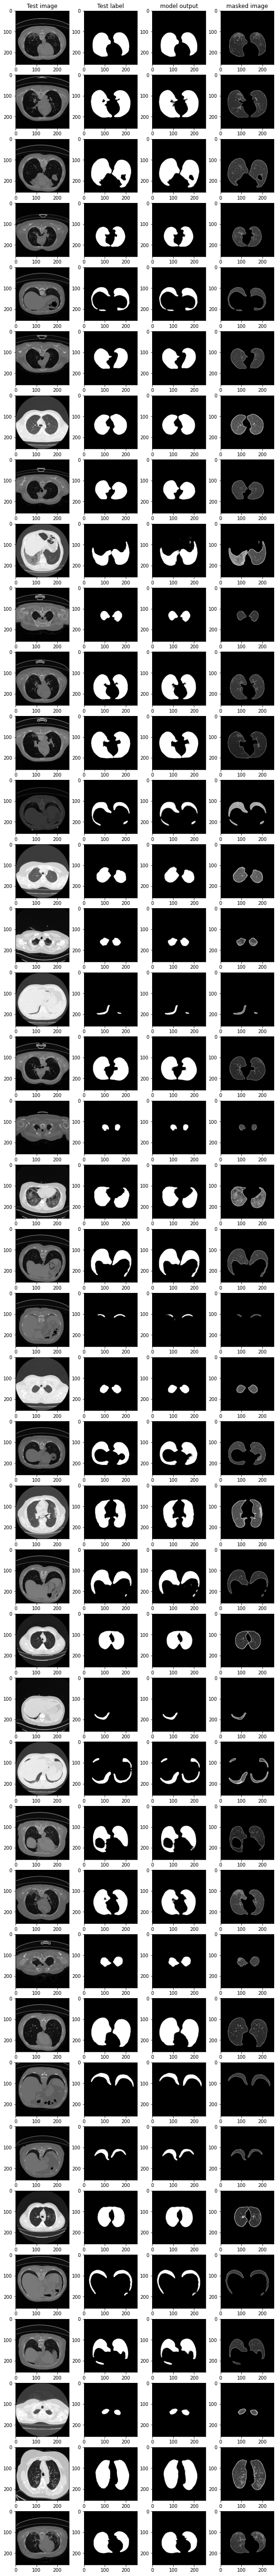

In [9]:
preds = model.predict(x_val)
fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 1), dtype=np.float32)

ax[0, 0].title.set_text("Test image")
ax[0, 1].title.set_text("Test label")
ax[0, 2].title.set_text("model output")
ax[0, 3].title.set_text("masked image")
for i in range(40):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    
    y_val_0 = y_val[...,0]
    ax[i, 1].imshow(y_val_0[i].squeeze(), cmap='gray')
    
    predict_0 = preds[...,0]
    ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
    
    temp = x_val[i]
    pred_sum = predict_0[i][predict_0[i] > 0]
    pred_mean = np.mean(predict_0)
    temp[predict_0[i] < 0.5] = 0
    ax[i, 3].imshow(temp.squeeze(), cmap='gray')
    

In [10]:
y_val_com_0 = y_val[...,0] #image label 
predict_com_0 = preds[...,0] #prediction (model output)

IOU_SUM = 0.0
IOU_AVE = 0.0
Number_image =0

for n,_ in enumerate(y_val_com_0) :
    
    TP = 0
    NP = 0
    index = n
    
    y_label_image = y_val_com_0[index].copy()
    predict_image = predict_com_0[index].copy()

    #model output 0번째 사진의 각 픽셀에 0.5보다 작으면 0 크면 1
    predict_image[predict_image < 0.5] = 0 
    predict_image[predict_image > 0.5] = 1

    #비교 해서 같으면 TP+1 아니면 NP+1
    for i in range(256) :
        for j in range(256) :
            if(y_label_image[i][j] == predict_image[i][j]) :
                TP = TP + 1
            else :
                NP = NP + 1

    print('Number : ', n, 'TP :', TP,'NP : ', NP)
    print('IOU :', TP/ (TP + NP) , '\n')
    IOU_SUM = TP/ (TP + NP) + IOU_SUM
    Number_image = n
    
IOU_AVE = IOU_SUM / (Number_image +  1)
print("IOU_AVE : ", IOU_AVE)


Number :  0 TP : 65371 NP :  165
IOU : 0.9974822998046875 

Number :  1 TP : 65180 NP :  356
IOU : 0.99456787109375 

Number :  2 TP : 65150 NP :  386
IOU : 0.994110107421875 

Number :  3 TP : 65384 NP :  152
IOU : 0.9976806640625 

Number :  4 TP : 65399 NP :  137
IOU : 0.9979095458984375 

Number :  5 TP : 65392 NP :  144
IOU : 0.997802734375 

Number :  6 TP : 65442 NP :  94
IOU : 0.998565673828125 

Number :  7 TP : 65440 NP :  96
IOU : 0.99853515625 

Number :  8 TP : 65208 NP :  328
IOU : 0.9949951171875 

Number :  9 TP : 65457 NP :  79
IOU : 0.9987945556640625 

Number :  10 TP : 65336 NP :  200
IOU : 0.9969482421875 

Number :  11 TP : 65220 NP :  316
IOU : 0.99517822265625 

Number :  12 TP : 65279 NP :  257
IOU : 0.9960784912109375 

Number :  13 TP : 65375 NP :  161
IOU : 0.9975433349609375 

Number :  14 TP : 65356 NP :  180
IOU : 0.99725341796875 

Number :  15 TP : 65477 NP :  59
IOU : 0.9990997314453125 

Number :  16 TP : 65387 NP :  149
IOU : 0.9977264404296875 

Num

Number :  137 TP : 65472 NP :  64
IOU : 0.9990234375 

Number :  138 TP : 65521 NP :  15
IOU : 0.9997711181640625 

Number :  139 TP : 65476 NP :  60
IOU : 0.99908447265625 

Number :  140 TP : 65204 NP :  332
IOU : 0.99493408203125 

Number :  141 TP : 65243 NP :  293
IOU : 0.9955291748046875 

Number :  142 TP : 65470 NP :  66
IOU : 0.998992919921875 

Number :  143 TP : 65306 NP :  230
IOU : 0.996490478515625 

Number :  144 TP : 65271 NP :  265
IOU : 0.9959564208984375 

Number :  145 TP : 65402 NP :  134
IOU : 0.997955322265625 

Number :  146 TP : 65317 NP :  219
IOU : 0.9966583251953125 

Number :  147 TP : 65207 NP :  329
IOU : 0.9949798583984375 

Number :  148 TP : 65427 NP :  109
IOU : 0.9983367919921875 

Number :  149 TP : 65514 NP :  22
IOU : 0.999664306640625 

Number :  150 TP : 65279 NP :  257
IOU : 0.9960784912109375 

Number :  151 TP : 65408 NP :  128
IOU : 0.998046875 

Number :  152 TP : 65380 NP :  156
IOU : 0.99761962890625 

Number :  153 TP : 65453 NP :  83
IO

Number :  272 TP : 65311 NP :  225
IOU : 0.9965667724609375 

Number :  273 TP : 65308 NP :  228
IOU : 0.99652099609375 

Number :  274 TP : 65465 NP :  71
IOU : 0.9989166259765625 

Number :  275 TP : 65345 NP :  191
IOU : 0.9970855712890625 

Number :  276 TP : 65420 NP :  116
IOU : 0.99822998046875 

Number :  277 TP : 65445 NP :  91
IOU : 0.9986114501953125 

Number :  278 TP : 65322 NP :  214
IOU : 0.996734619140625 

Number :  279 TP : 65258 NP :  278
IOU : 0.995758056640625 

Number :  280 TP : 65432 NP :  104
IOU : 0.9984130859375 

Number :  281 TP : 65107 NP :  429
IOU : 0.9934539794921875 

Number :  282 TP : 65321 NP :  215
IOU : 0.9967193603515625 

Number :  283 TP : 65261 NP :  275
IOU : 0.9958038330078125 

Number :  284 TP : 65260 NP :  276
IOU : 0.99578857421875 

Number :  285 TP : 65184 NP :  352
IOU : 0.99462890625 

Number :  286 TP : 65291 NP :  245
IOU : 0.9962615966796875 

Number :  287 TP : 65276 NP :  260
IOU : 0.99603271484375 

Number :  288 TP : 65060 NP 